# ABC calibration of $I_\text{Na}$ in standardised model to unified dataset.

In [1]:
import os, tempfile
import logging
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
from ionchannelABC import theoretical_population_size
from ionchannelABC import IonChannelDistance, EfficientMultivariateNormalTransition, IonChannelAcceptor
from ionchannelABC.experiment import setup
from ionchannelABC.visualization import plot_sim_results, plot_kde_matrix_custom
import myokit

INFO:myokit:Loading Myokit version 1.29.1


In [3]:
from pyabc import Distribution, RV, History, ABCSMC
from pyabc.epsilon import MedianEpsilon
from pyabc.sampler import MulticoreEvalParallelSampler, SingleCoreSampler
from pyabc.populationstrategy import ConstantPopulationSize

## Initial set-up

Load experiments used for unified dataset calibration:
 - Steady-state activation [Sakakibara1992]
 - Activation time constant [Schneider1994]
 - Steady-state inactivation [Sakakibara1992]
 - Inactivation time constant (fast+slow) [Sakakibara1992]
 - Recovery time constant (fast+slow) [Sakakibara1992]

In [4]:
from experiments.ina_sakakibara import (sakakibara_act_nyg_adjust,
                                        sakakibara_inact_nyg_adjust,
                                        sakakibara_inact_kin_nyg_adjust,
                                        sakakibara_rec_nyg_adjust)
from experiments.ina_schneider import schneider_taum_nyg_adjust

In [5]:
modelfile = 'models/standardised_ina.mmt'

Combine model and experiments to produce:
 - observations dataframe
 - model function to run experiments and return traces
 - summary statistics function to accept traces

In [6]:
observations, model, summary_statistics = setup(modelfile,
                                                sakakibara_act_nyg_adjust,
                                                sakakibara_inact_nyg_adjust,
                                                schneider_taum_nyg_adjust,
                                                sakakibara_inact_kin_nyg_adjust,
                                                sakakibara_rec_nyg_adjust)

In [7]:
assert len(observations)==len(summary_statistics(model({})))

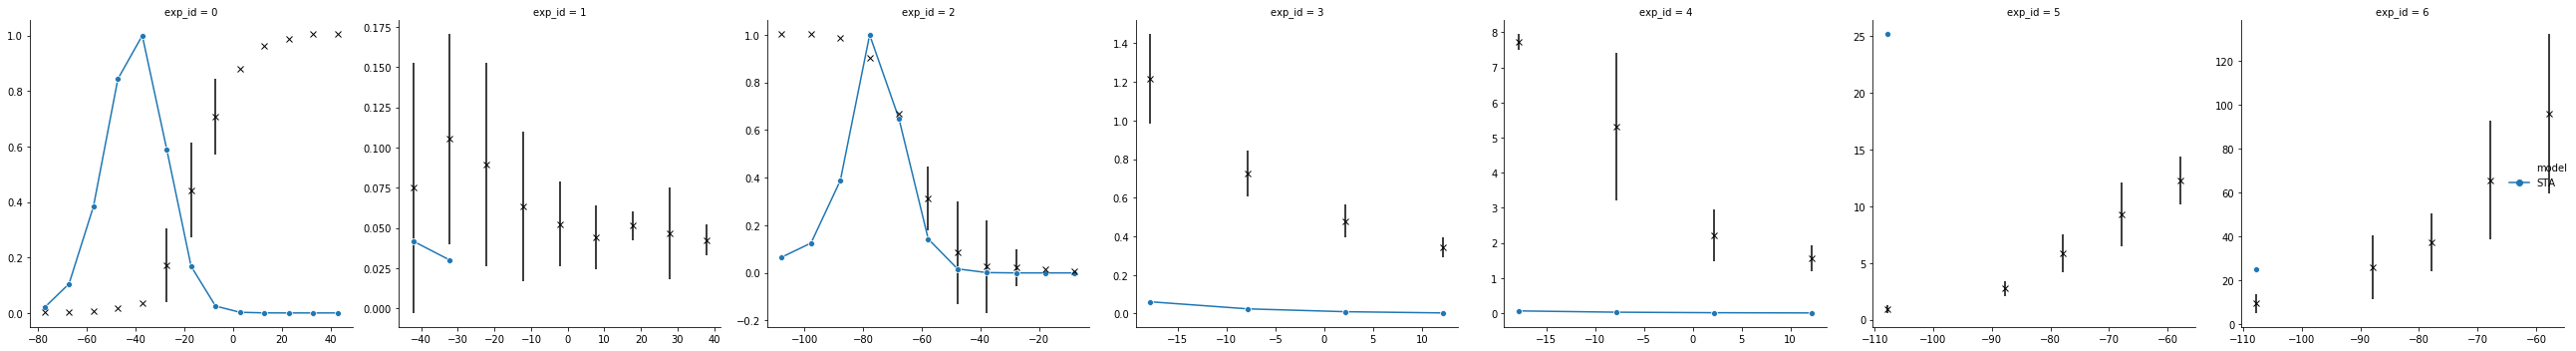

In [8]:
g = plot_sim_results(modelfile,
                     sakakibara_act_nyg_adjust,
                     schneider_taum_nyg_adjust,
                     sakakibara_inact_nyg_adjust,
                     sakakibara_inact_kin_nyg_adjust,
                     sakakibara_rec_nyg_adjust)

### Set up prior ranges for each parameter in the model.

See the modelfile for further information on specific parameters. Prepending `log_' has the effect of setting the parameter in log space.

In [7]:
limits = {'log_ina.A': (0., 1.),
          'log_ina.p_1': (1., 5.),
          'ina.p_2': (1e-7, 0.2),
          'log_ina.p_3': (-3., 1.),
          'ina.p_4': (1e-7, 0.4),
          'log_ina.p_5': (-1., 3.),
          'ina.p_6': (1e-7, 0.2),
          'log_ina.p_7': (-4., 0.),
          'ina.p_8': (1e-7, 0.2)}
prior = Distribution(**{key: RV("uniform", a, b - a)
                        for key, (a,b) in limits.items()})

In [8]:
# Test this works correctly with set-up functions
assert len(observations) == len(summary_statistics(model(prior.rvs())))

### Run ABC calibration

In [9]:
db_path = ("sqlite:///" + os.path.join(tempfile.gettempdir(), "standardised_ina_unified.db"))

In [12]:
logging.basicConfig()
abc_logger = logging.getLogger('ABC')
abc_logger.setLevel(logging.DEBUG)
eps_logger = logging.getLogger('Epsilon')
eps_logger.setLevel(logging.DEBUG)

In [13]:
pop_size = theoretical_population_size(2, len(limits))
print("Theoretical minimum population size is {} particles".format(pop_size))

Theoretical minimum population size is 512 particles


In [14]:
abc = ABCSMC(models=model,
             parameter_priors=prior,
             distance_function=IonChannelDistance(
                 exp_id=list(observations.exp_id),
                 variance=list(observations.variance),
                 delta=0.05),
             population_size=ConstantPopulationSize(1000),
             summary_statistics=summary_statistics,
             transitions=EfficientMultivariateNormalTransition(),
             eps=MedianEpsilon(initial_epsilon=100),
             sampler=MulticoreEvalParallelSampler(n_procs=16),
             acceptor=IonChannelAcceptor())

DEBUG:ABC:ion channel weights: {'0': 0.9521382851835398, '1': 0.9521382851835398, '2': 0.9521382851835398, '3': 0.9521382851835398, '4': 0.9521382851835398, '5': 0.3610802157587068, '6': 0.28091899218602906, '7': 0.34916236031070585, '8': 0.9521382851835398, '9': 0.9521382851835398, '10': 0.9521382851835398, '11': 0.9521382851835398, '12': 0.9521382851835398, '13': 1.1252543370350925, '14': 1.1252543370350925, '15': 1.1252543370350925, '16': 1.1252543370350925, '17': 1.1252543370350925, '18': 0.42207751211772393, '19': 0.2622965124637598, '20': 0.2905205191839746, '21': 0.7247875556726021, '22': 1.1252543370350925, '23': 1.1252543370350925, '24': 0.09316342544404477, '25': 0.11125161472106908, '26': 0.11495918910006203, '27': 0.15597691589531334, '28': 0.27468055746289666, '29': 0.3630417376464485, '30': 0.8062952607338584, '31': 0.2544213362366676, '32': 0.7664744141929603, '33': 0.808383669750957, '34': 1.5915053498221963, '35': 2.2142683127961, '36': 3.0944494268465044, '37': 3.0944

In [15]:
obs = observations.to_dict()['y']
obs = {str(k): v for k, v in obs.items()}

In [16]:
abc_id = abc.new(db_path, obs)

INFO:History:Start <ABCSMC(id=1, start_time=2019-12-17 06:33:59.565854, end_time=None)>


In [17]:
history = abc.run(minimum_epsilon=0., max_nr_populations=100, min_acceptance_rate=0.01)

INFO:ABC:t: 0, eps: 100.
DEBUG:ABC:Now submitting population 0.
DEBUG:ABC:Population 0 done.
DEBUG:ABC:Total samples up to t = 0: 43612.
INFO:ABC:Acceptance rate: 1000 / 43612 = 2.2929e-02.
DEBUG:Epsilon:new eps, t=1, eps=9.14057036778891
INFO:ABC:t: 1, eps: 9.14057036778891.
DEBUG:ABC:Now submitting population 1.
DEBUG:ABC:Population 1 done.
DEBUG:ABC:Total samples up to t = 1: 47022.
INFO:ABC:Acceptance rate: 1000 / 3410 = 2.9326e-01.
DEBUG:Epsilon:new eps, t=2, eps=3.9136999627104734
INFO:ABC:t: 2, eps: 3.9136999627104734.
DEBUG:ABC:Now submitting population 2.
DEBUG:ABC:Population 2 done.
DEBUG:ABC:Total samples up to t = 2: 50748.
INFO:ABC:Acceptance rate: 1000 / 3726 = 2.6838e-01.
DEBUG:Epsilon:new eps, t=3, eps=3.1353252234520474
INFO:ABC:t: 3, eps: 3.1353252234520474.
DEBUG:ABC:Now submitting population 3.
DEBUG:ABC:Population 3 done.
DEBUG:ABC:Total samples up to t = 3: 55358.
INFO:ABC:Acceptance rate: 1000 / 4610 = 2.1692e-01.
DEBUG:Epsilon:new eps, t=4, eps=2.618202072412598

INFO:ABC:Acceptance rate: 1000 / 41874 = 2.3881e-02.
DEBUG:Epsilon:new eps, t=33, eps=0.7444875993944547
INFO:ABC:t: 33, eps: 0.7444875993944547.
DEBUG:ABC:Now submitting population 33.
DEBUG:ABC:Population 33 done.
DEBUG:ABC:Total samples up to t = 33: 460711.
INFO:ABC:Acceptance rate: 1000 / 46774 = 2.1379e-02.
DEBUG:Epsilon:new eps, t=34, eps=0.7411939605323628
INFO:ABC:t: 34, eps: 0.7411939605323628.
DEBUG:ABC:Now submitting population 34.
DEBUG:ABC:Population 34 done.
DEBUG:ABC:Total samples up to t = 34: 515099.
INFO:ABC:Acceptance rate: 1000 / 54388 = 1.8386e-02.
DEBUG:Epsilon:new eps, t=35, eps=0.7380772270233786
INFO:ABC:t: 35, eps: 0.7380772270233786.
DEBUG:ABC:Now submitting population 35.
DEBUG:ABC:Population 35 done.
DEBUG:ABC:Total samples up to t = 35: 579313.
INFO:ABC:Acceptance rate: 1000 / 64214 = 1.5573e-02.
DEBUG:Epsilon:new eps, t=36, eps=0.7350625750429415
INFO:ABC:t: 36, eps: 0.7350625750429415.
DEBUG:ABC:Now submitting population 36.
DEBUG:ABC:Population 36 done

In [18]:
history = abc.run(minimum_epsilon=0., max_nr_populations=100, min_acceptance_rate=0.01)

INFO:ABC:t: 39, eps: 0.7268430798679028.
DEBUG:ABC:Now submitting population 39.
DEBUG:ABC:Population 39 done.
DEBUG:ABC:Total samples up to t = 39: 879741.
INFO:ABC:Acceptance rate: 1000 / 61112 = 1.6363e-02.
DEBUG:Epsilon:new eps, t=40, eps=0.7247925818488905
INFO:ABC:t: 40, eps: 0.7247925818488905.
DEBUG:ABC:Now submitting population 40.
DEBUG:ABC:Population 40 done.
DEBUG:ABC:Total samples up to t = 40: 942207.
INFO:ABC:Acceptance rate: 1000 / 62466 = 1.6009e-02.
DEBUG:Epsilon:new eps, t=41, eps=0.722771993047105
INFO:ABC:t: 41, eps: 0.722771993047105.
DEBUG:ABC:Now submitting population 41.
DEBUG:ABC:Population 41 done.
DEBUG:ABC:Total samples up to t = 41: 1043693.
INFO:ABC:Acceptance rate: 1000 / 101486 = 9.8536e-03.
DEBUG:Epsilon:new eps, t=42, eps=0.7209793386851976
INFO:History:Done <ABCSMC(id=1, start_time=2019-12-17 06:33:59.565854, end_time=2019-12-17 22:55:54.234738)>


### Results analysis

In [10]:
history = History(db_path)

In [11]:
history.all_runs() # most recent is relevant

[<ABCSMC(id=1, start_time=2019-12-17 06:33:59.565854, end_time=2019-12-17 22:55:54.234738)>]

In [12]:
df, w = history.get_distribution( m=0)

In [13]:
df.describe()

name,ina.p_2,ina.p_4,ina.p_6,ina.p_8,log_ina.A,log_ina.p_1,log_ina.p_3,log_ina.p_5,log_ina.p_7
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,0.116073,0.060670,0.044577,0.041046,0.624449,2.062067,-0.031220,0.178759,-1.720154
std,0.009188,0.028784,0.001029,0.001268,0.006774,0.052642,0.367158,0.010187,0.044371
min,0.085359,0.000279,0.042072,0.036092,0.599608,1.830919,-1.874897,0.140543,-1.866860
25%,0.110542,0.042642,0.043839,0.040551,0.620599,2.045324,-0.214565,0.173101,-1.745358
50%,0.116725,0.060299,0.044543,0.041141,0.624581,2.070177,-0.039007,0.180036,-1.723305
75%,0.121772,0.077671,0.045284,0.041741,0.628348,2.094471,0.145484,0.185479,-1.702154
max,0.145344,0.215732,0.047697,0.045072,0.650242,2.181885,0.741621,0.202705,-1.547891


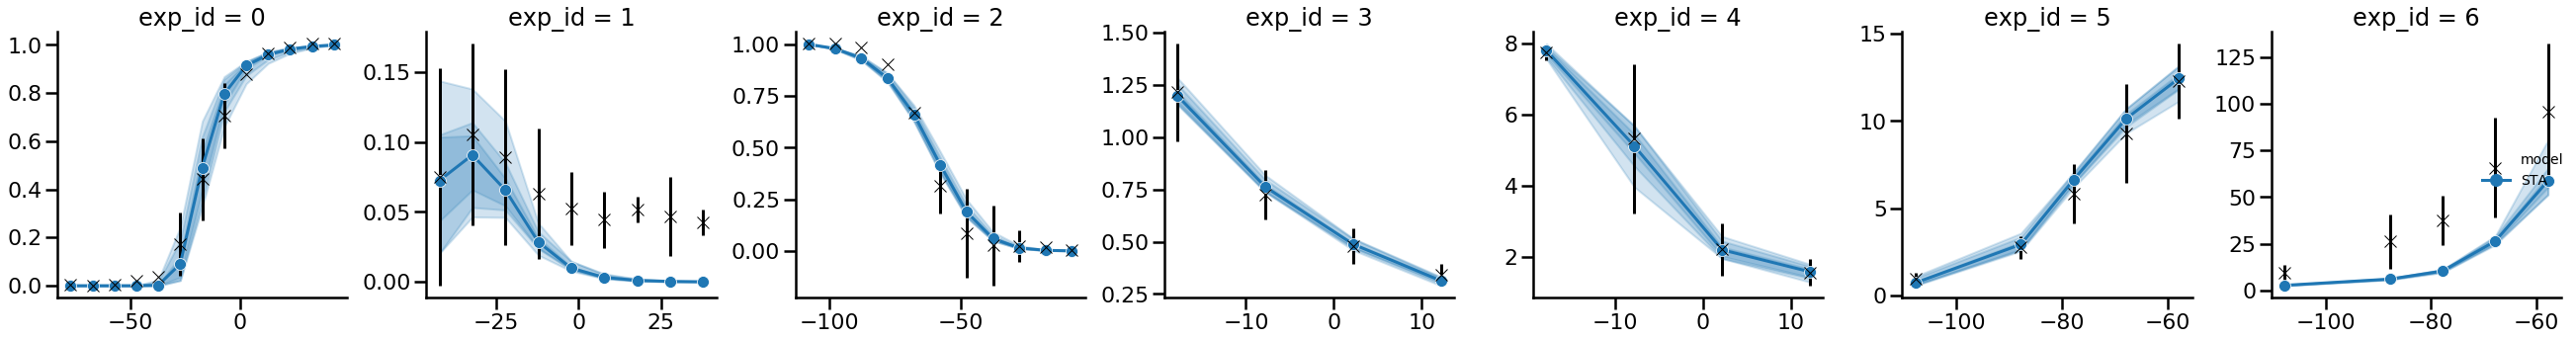

In [14]:
sns.set_context('poster')

mpl.rcParams['font.size'] = 14
mpl.rcParams['legend.fontsize'] = 14

g = plot_sim_results(modelfile,
                     sakakibara_act_nyg_adjust,
                     schneider_taum_nyg_adjust,
                     sakakibara_inact_nyg_adjust,
                     sakakibara_inact_kin_nyg_adjust,
                     sakakibara_rec_nyg_adjust,
                     df=df, w=w)

plt.tight_layout()

In [15]:
m,_,_ = myokit.load(modelfile)

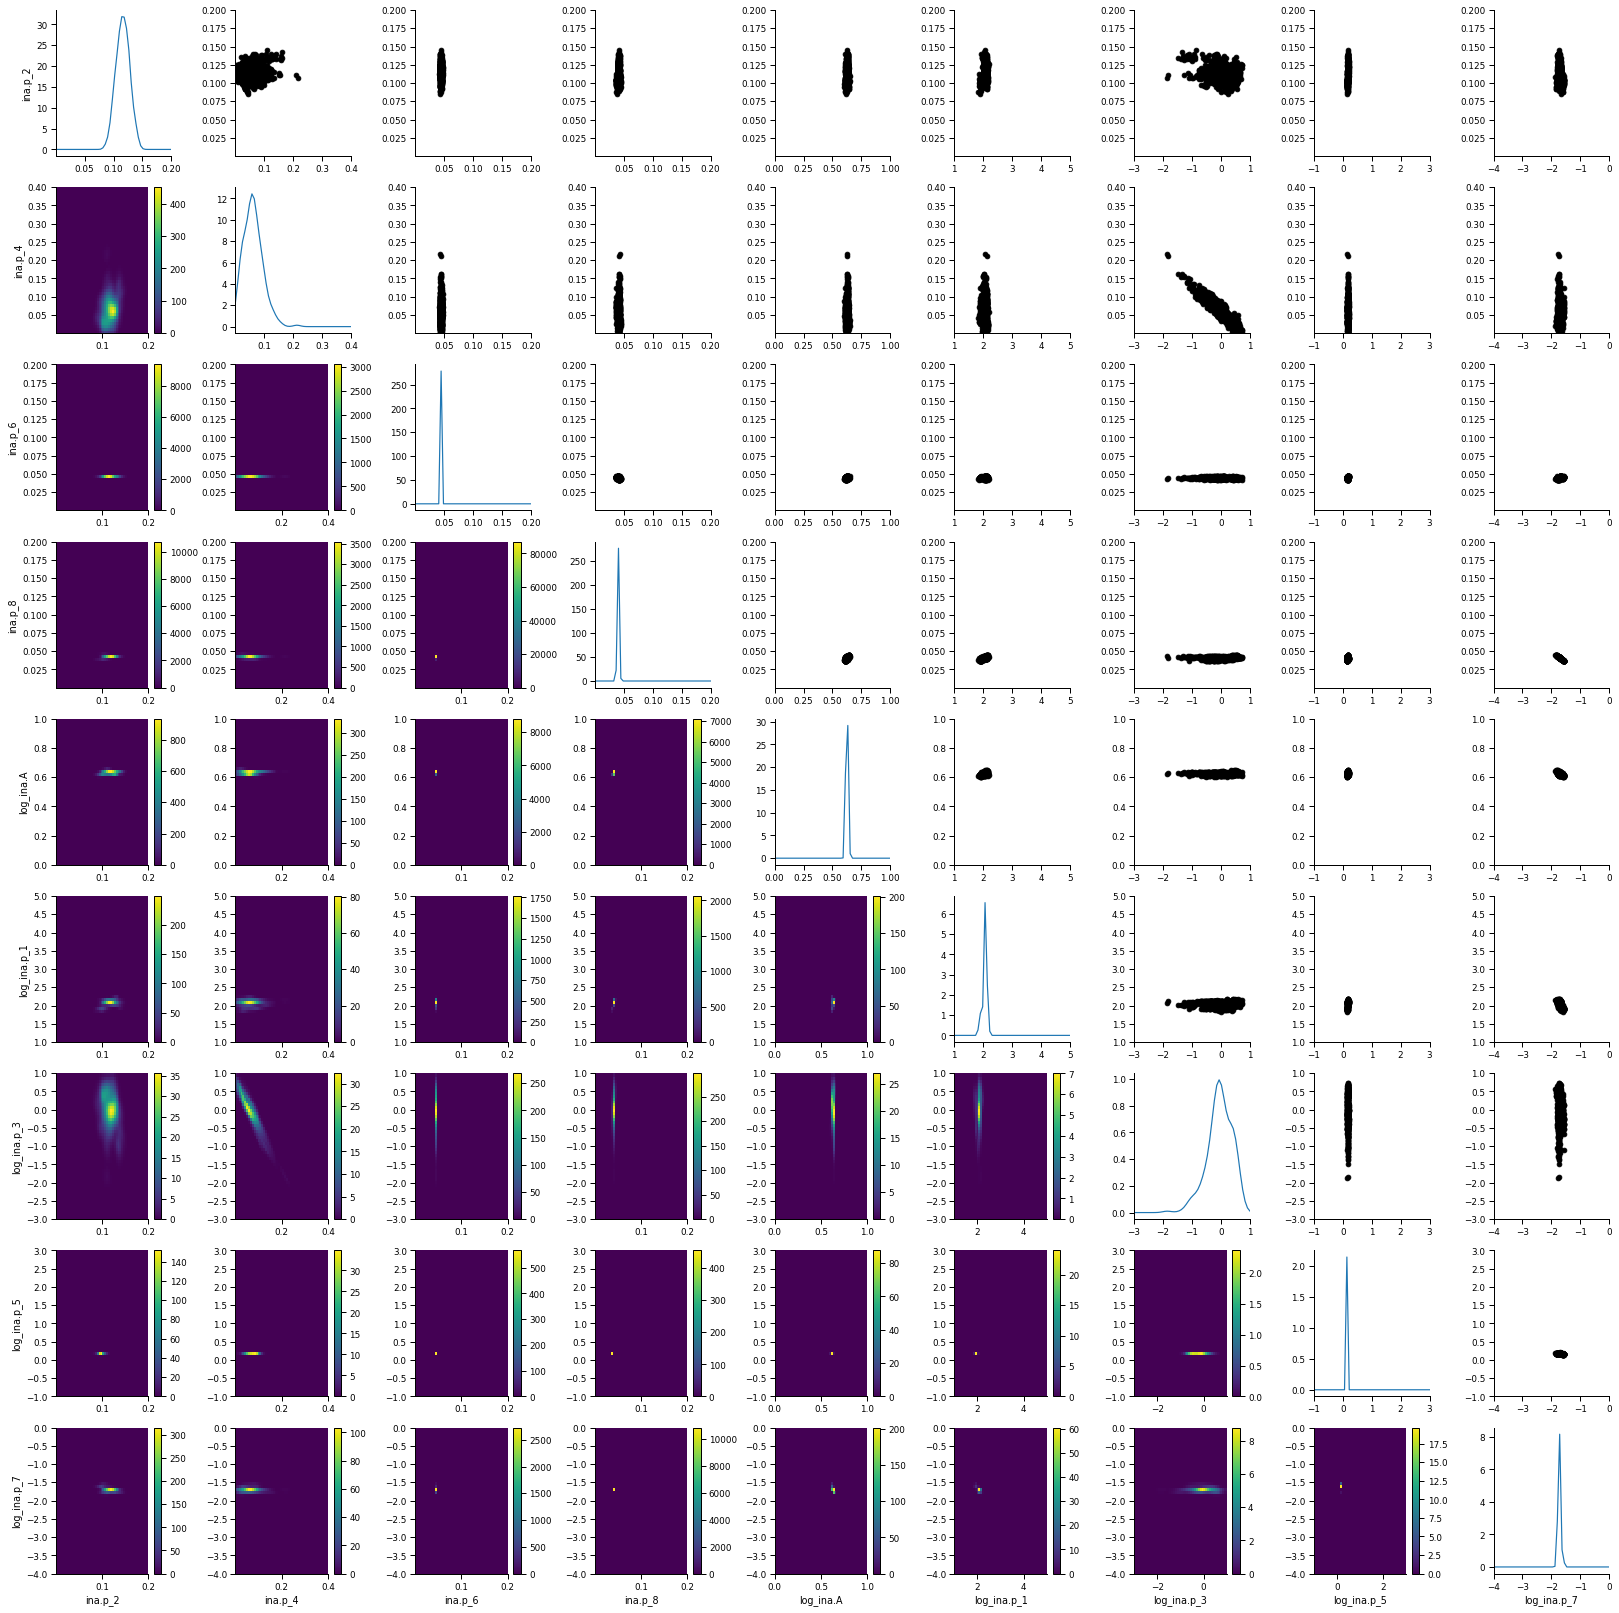

In [16]:
sns.set_context('paper')
g = plot_kde_matrix_custom(df, w, limits=limits)
plt.tight_layout()